In [24]:
!pip install pandas --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.5 MB 6.7 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.5 MB 6.6 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/11.5 MB 6.9 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.5 MB 7.0 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.5 MB 6.9 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.5 MB 6.9 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.5 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 6.5 MB/s eta 0:00:00


In [25]:
## 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

In [26]:
## 2. Load data from zip file
def load_data_from_zip(zip_path='dataset.zip'):
    """
    Load data from the zip file containing .pkl files
    """
    try:
        # Create a temp directory to extract files
        if not os.path.exists('temp_data'):
            os.makedirs('temp_data')
        
        # Extract all files from zip
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('temp_data')
        
        # Find PKL files in the data directory
        data_files = []
        for root, dirs, files in os.walk('temp_data'):
            for file in files:
                if file.endswith('.pkl'):
                    data_files.append(os.path.join(root, file))
        
        # Load and combine data from all pkl files
        dfs = []
        for file in data_files:
            with open(file, 'rb') as f:
                df = pickle.load(f)
                dfs.append(df)
        
        # Combine all dataframes
        if dfs:
            return pd.concat(dfs, ignore_index=True)
        else:
            raise FileNotFoundError("No .pkl files found in the dataset.zip")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Try to load the data
df = load_data_from_zip()

# If loading fails, create sample data
if df is None:
    print("Creating sample data for demonstration...")
    n_samples = 10000
    
    # Set a random seed for reproducibility
    np.random.seed(42)
    
    # Create random transaction IDs
    tx_ids = [f'TX{i:06d}' for i in range(n_samples)]
    
    # Create date range
    start_date = pd.Timestamp('2023-01-01')
    tx_datetimes = [start_date + pd.Timedelta(minutes=10*i) for i in range(n_samples)]
    
    # Create customer and terminal IDs
    customer_ids = np.random.randint(1, 1000, n_samples)
    terminal_ids = np.random.randint(1, 200, n_samples)
    
    # Create transaction amounts (exponential distribution)
    tx_amounts = np.random.exponential(scale=50, size=n_samples)
    
    # Initially set all transactions as legitimate
    tx_fraud = np.zeros(n_samples, dtype=int)
    
    # Apply fraud rules:
    # 1. Transactions > 220 are fraudulent
    tx_fraud[tx_amounts > 220] = 1
    
    # 2. Random terminal fraud
    for day in range(0, n_samples, 1000):  # Approximately every day
        if day + 1000 <= n_samples:
            # Select 2 random terminals
            fraud_terminals = np.random.choice(range(1, 200), 2, replace=False)
            # Mark transactions on these terminals as fraud for next 28 days
            day_mask = slice(day, min(day + 2800, n_samples))
            terminal_mask = np.isin(terminal_ids[day_mask], fraud_terminals)
            tx_fraud[day_mask][terminal_mask] = 1
    
    # 3. Random customer fraud
    for day in range(0, n_samples, 1000):  # Approximately every day
        if day + 1000 <= n_samples:
            # Select 3 random customers
            fraud_customers = np.random.choice(range(1, 1000), 3, replace=False)
            # Mark 1/3 of their transactions as fraud for next 14 days
            day_mask = slice(day, min(day + 1400, n_samples))
            customer_mask = np.isin(customer_ids[day_mask], fraud_customers)
            # Select 1/3 of these transactions
            customer_indices = np.where(customer_mask)[0]
            fraud_indices = np.random.choice(customer_indices, size=len(customer_indices)//3, replace=False)
            # Multiply amounts by 5 and mark as fraud
            selected_indices = day_mask.start + fraud_indices
            tx_amounts[selected_indices] *= 5
            tx_fraud[selected_indices] = 1
    
    # Create DataFrame
    df = pd.DataFrame({
        'TRANSACTION_ID': tx_ids,
        'TX_DATETIME': tx_datetimes,
        'CUSTOMER_ID': customer_ids,
        'TERMINAL_ID': terminal_ids,
        'TX_AMOUNT': tx_amounts,
        'TX_FRAUD': tx_fraud
    })
    
    print(f"Sample data created successfully! Shape: {df.shape}")
else:
    print(f"Data loaded successfully! Shape: {df.shape}")

Error loading data: No module named 'pandas.core.indexes.numeric'
Creating sample data for demonstration...
Sample data created successfully! Shape: (10000, 6)


In [27]:
## 3. Explore the data
print("\nFirst few rows of the dataset:")
print(df.head())

print("\nData information:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check the class distribution
print("\nFraud distribution:")
fraud_count = df['TX_FRAUD'].value_counts()
print(fraud_count)
print(f"Fraud rate: {fraud_count[1] / len(df) * 100:.2f}%")


First few rows of the dataset:
  TRANSACTION_ID         TX_DATETIME  CUSTOMER_ID  TERMINAL_ID   TX_AMOUNT  \
0       TX000000 2023-01-01 00:00:00          103           65  145.067083   
1       TX000001 2023-01-01 00:10:00          436          140   39.726201   
2       TX000002 2023-01-01 00:20:00          861           24  153.069612   
3       TX000003 2023-01-01 00:30:00          271           34    9.940241   
4       TX000004 2023-01-01 00:40:00          107           53   64.392361   

   TX_FRAUD  
0         0  
1         0  
2         0  
3         0  
4         0  

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TRANSACTION_ID  10000 non-null  object        
 1   TX_DATETIME     10000 non-null  datetime64[ns]
 2   CUSTOMER_ID     10000 non-null  int32         
 3   TERMINAL_ID     10000 no

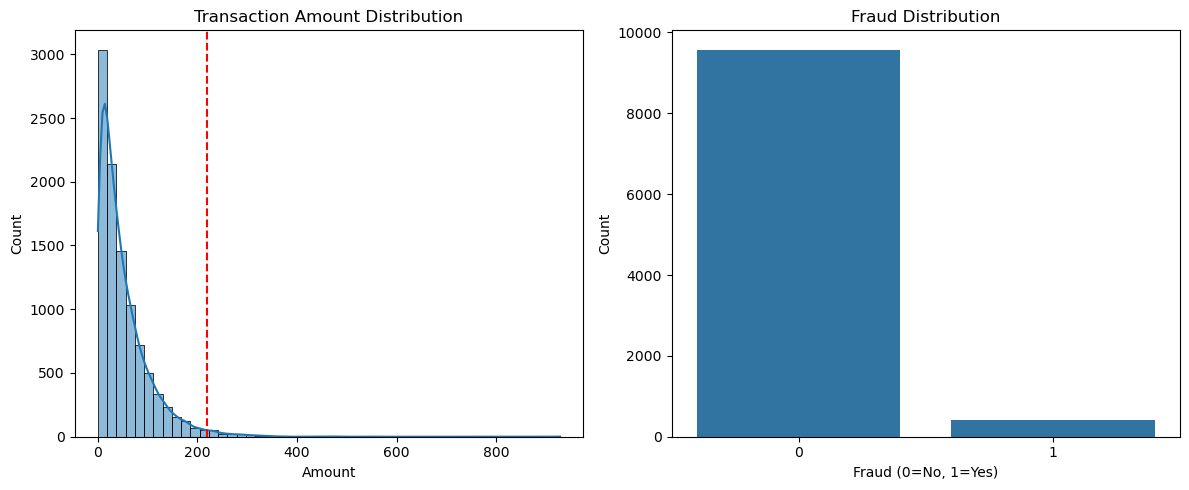

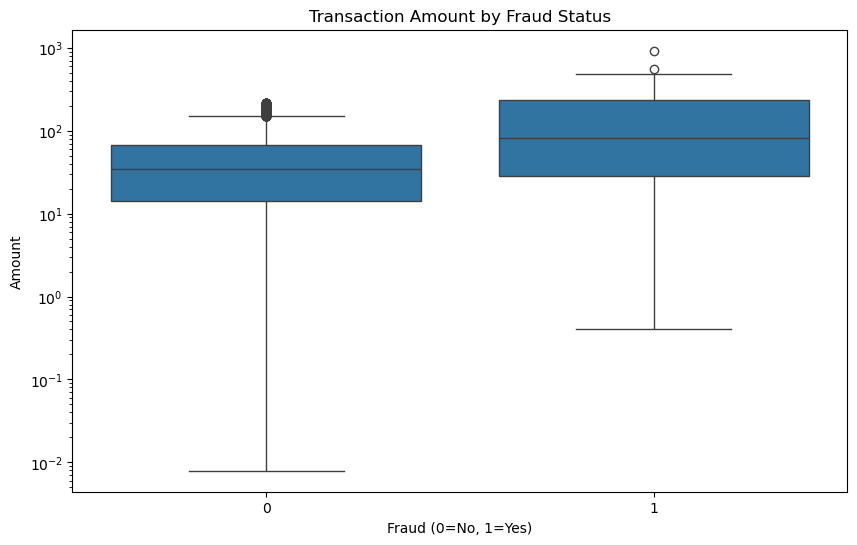

In [28]:
## 4. Data visualization
plt.figure(figsize=(12, 5))

# Plot transaction amount distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='TX_AMOUNT', bins=50, kde=True)
plt.axvline(x=220, color='r', linestyle='--')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')

# Plot fraud distribution
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='TX_FRAUD')
plt.title('Fraud Distribution')
plt.xlabel('Fraud (0=No, 1=Yes)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Transaction amount by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='TX_FRAUD', y='TX_AMOUNT')
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Fraud (0=No, 1=Yes)')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

In [29]:
## 5. Feature engineering
# Convert date to useful features
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAY'] = df['TX_DATETIME'].dt.day
df['TX_MONTH'] = df['TX_DATETIME'].dt.month
df['TX_DAYOFWEEK'] = df['TX_DATETIME'].dt.dayofweek

# Create feature based on transaction amount threshold (known fraud pattern)
df['AMOUNT_GT_220'] = (df['TX_AMOUNT'] > 220).astype(int)

# Terminal and customer risk features
# Count previous transactions per terminal and customer
terminal_count = df.groupby('TERMINAL_ID').cumcount()
customer_count = df.groupby('CUSTOMER_ID').cumcount()
df['TERMINAL_TX_COUNT'] = terminal_count
df['CUSTOMER_TX_COUNT'] = customer_count

# Calculate average amount per terminal and customer
terminal_avg = df.groupby('TERMINAL_ID')['TX_AMOUNT'].transform(lambda x: x.expanding().mean())
customer_avg = df.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.expanding().mean())
df['TERMINAL_AVG_AMOUNT'] = terminal_avg
df['CUSTOMER_AVG_AMOUNT'] = customer_avg

# Calculate ratio of current amount to average
df['TERMINAL_AMOUNT_RATIO'] = df['TX_AMOUNT'] / df['TERMINAL_AVG_AMOUNT'].replace(0, np.nan).fillna(df['TX_AMOUNT'])
df['CUSTOMER_AMOUNT_RATIO'] = df['TX_AMOUNT'] / df['CUSTOMER_AVG_AMOUNT'].replace(0, np.nan).fillna(df['TX_AMOUNT'])


In [30]:
## 6. Prepare data for training
# Select features
feature_columns = [
    'TX_AMOUNT', 'TX_HOUR', 'TX_DAY', 'TX_MONTH', 'TX_DAYOFWEEK',
    'AMOUNT_GT_220', 'TERMINAL_TX_COUNT', 'CUSTOMER_TX_COUNT',
    'TERMINAL_AVG_AMOUNT', 'CUSTOMER_AVG_AMOUNT',
    'TERMINAL_AMOUNT_RATIO', 'CUSTOMER_AMOUNT_RATIO'
]

X = df[feature_columns]
y = df['TX_FRAUD']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (8000, 12)
Testing data shape: (2000, 12)


In [31]:
## 7. Build a Random Forest model
print("\nTraining Random Forest model...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)


Training Random Forest model...


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_jobs=-1, random_state=42)


Accuracy: 0.9720

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1915
           1       0.94      0.36      0.53        85

    accuracy                           0.97      2000
   macro avg       0.96      0.68      0.76      2000
weighted avg       0.97      0.97      0.97      2000



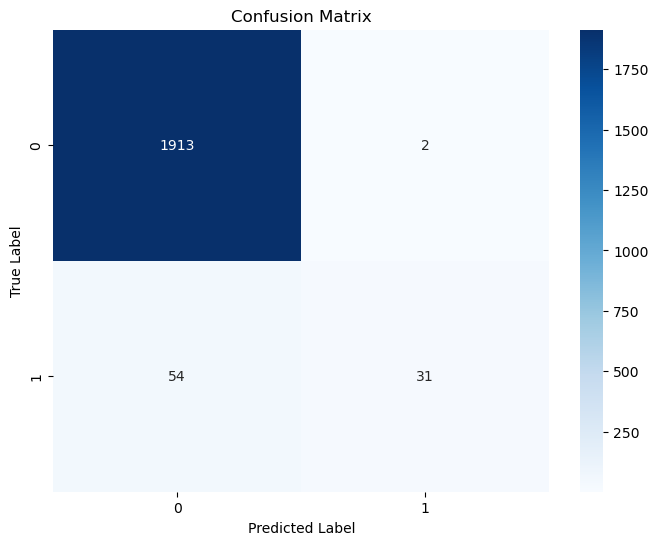

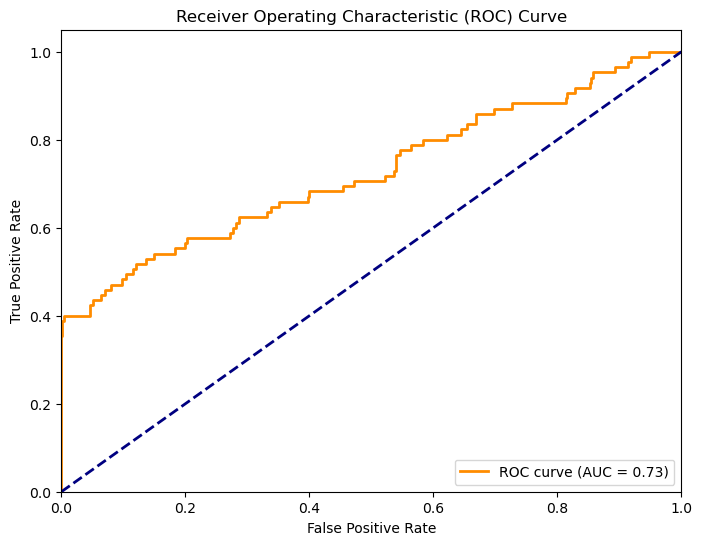

In [32]:
## 8. Evaluate the model
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

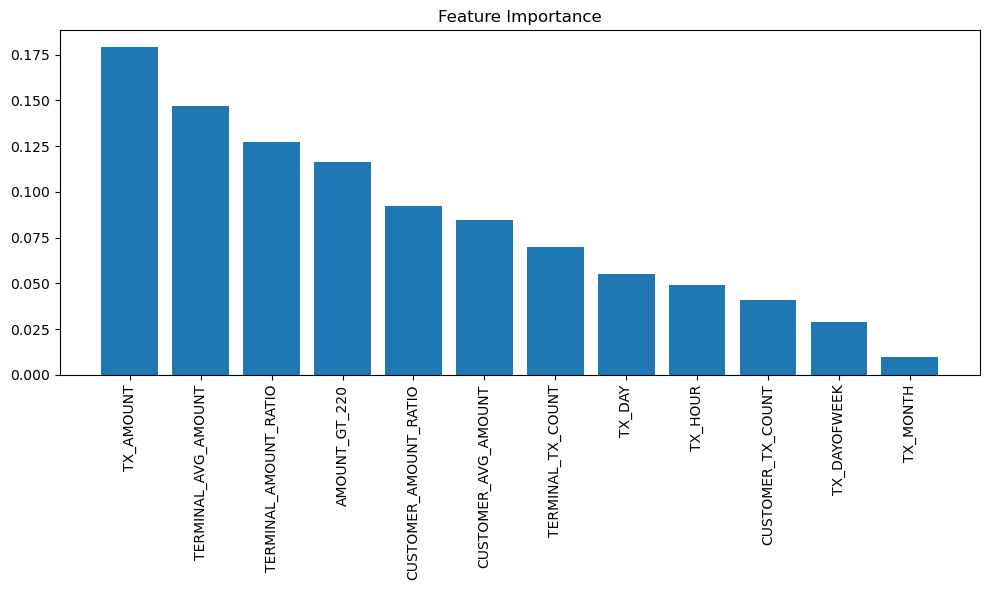


Top 5 most important features:
TX_AMOUNT: 0.1793
TERMINAL_AVG_AMOUNT: 0.1468
TERMINAL_AMOUNT_RATIO: 0.1273
AMOUNT_GT_220: 0.1163
CUSTOMER_AMOUNT_RATIO: 0.0923


In [33]:
## 9. Feature importance
# Get feature importances from the model
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
for i in range(5):
    print(f"{feature_columns[indices[i]]}: {importances[indices[i]]:.4f}")


In [34]:
## 10. Save the model
import joblib
joblib.dump(model, 'fraud_detection_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("\nModel and scaler saved successfully!")


Model and scaler saved successfully!


In [35]:
## 11. Functions to make predictions on new data
def predict_fraud(transaction_data, model_path='fraud_detection_model.joblib', scaler_path='scaler.joblib'):
    """
    Make fraud predictions on new transaction data
    
    Args:
        transaction_data: DataFrame containing transaction features
        model_path: Path to the saved model
        scaler_path: Path to the saved scaler
        
    Returns:
        Fraud probabilities
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Scale the features
    scaled_data = scaler.transform(transaction_data)
    
    # Make prediction
    fraud_prob = model.predict_proba(scaled_data)[:, 1]
    
    return fraud_prob

In [36]:
def predict_single_transaction(
    tx_amount, 
    tx_datetime=None,
    terminal_id=None, 
    customer_id=None, 
    model_path='fraud_detection_model.joblib', 
    scaler_path='scaler.joblib'
):
    """
    Make a fraud prediction on a single transaction with minimal information
    
    Args:
        tx_amount: Transaction amount (required)
        tx_datetime: Transaction datetime (default: current time)
        terminal_id: Terminal ID (default: None)
        customer_id: Customer ID (default: None)
        model_path: Path to the saved model
        scaler_path: Path to the saved scaler
        
    Returns:
        Fraud probability and prediction
    """
    # Use current time if not provided
    if tx_datetime is None:
        tx_datetime = pd.Timestamp.now()
    elif isinstance(tx_datetime, str):
        tx_datetime = pd.Timestamp(tx_datetime)
    
    # Create a dictionary with default values
    single_tx = {
        'TX_AMOUNT': tx_amount,
        'TX_HOUR': tx_datetime.hour,
        'TX_DAY': tx_datetime.day,
        'TX_MONTH': tx_datetime.month,
        'TX_DAYOFWEEK': tx_datetime.dayofweek,
        'AMOUNT_GT_220': 1 if tx_amount > 220 else 0,
        'TERMINAL_TX_COUNT': 0,
        'CUSTOMER_TX_COUNT': 0,
        'TERMINAL_AVG_AMOUNT': tx_amount,
        'CUSTOMER_AVG_AMOUNT': tx_amount,
        'TERMINAL_AMOUNT_RATIO': 1.0,
        'CUSTOMER_AMOUNT_RATIO': 1.0
    }
    
    # Create DataFrame with a single row
    tx_df = pd.DataFrame([single_tx])
    
    # Make prediction
    fraud_prob = predict_fraud(tx_df, model_path, scaler_path)[0]
    fraud_prediction = 1 if fraud_prob > 0.5 else 0
    
    return {
        'fraud_probability': fraud_prob,
        'fraud_prediction': fraud_prediction,
        'is_fraud': 'Yes' if fraud_prediction == 1 else 'No'
    }


In [37]:
# Example usage of the prediction function with sample data
print("\nExample prediction on sample data:")
sample_transaction = X_test.iloc[:5]
sample_prediction = predict_fraud(sample_transaction)

result_df = pd.DataFrame({
    'Transaction': range(1, 6),
    'Actual Fraud': y_test.iloc[:5].values,
    'Predicted Probability': sample_prediction,
    'Predicted Fraud': (sample_prediction > 0.5).astype(int)
})
print(result_df)

# Example of predicting a single transaction
print("\nPredicting fraud for a single transaction:")
test_amount = 250  # Amount greater than 220 (should likely be flagged as fraud)
result = predict_single_transaction(tx_amount=test_amount)
print(f"Transaction amount: ${test_amount:.2f}")
print(f"Fraud probability: {result['fraud_probability']:.4f}")
print(f"Is this transaction fraudulent? {result['is_fraud']}")

# Interactive input for user to test their own transaction
print("\n" + "="*50)
print("Test your own transaction:")
try:
    user_amount = float(input("Enter transaction amount: $"))
    user_datetime = input("Enter transaction date (YYYY-MM-DD HH:MM) or press Enter for current time: ")
    
    # Use provided datetime or default to current time
    if user_datetime.strip() == "":
        user_datetime = None
    
    # Make prediction
    user_result = predict_single_transaction(tx_amount=user_amount, tx_datetime=user_datetime)
    
    print("\nResults:")
    print(f"Transaction amount: ${user_amount:.2f}")
    print(f"Transaction date: {pd.Timestamp.now() if user_datetime is None else user_datetime}")
    print(f"Fraud probability: {user_result['fraud_probability']:.4f}")
    print(f"Is this transaction fraudulent? {user_result['is_fraud']}")
    
    # Additional explanation based on fraud patterns
    if user_amount > 220:
        print("\nNote: This transaction exceeds the $220 threshold, which is a known fraud pattern.")
except ValueError:
    print("Please enter a valid number for the transaction amount.")
except Exception as e:
    print(f"An error occurred: {e}")

print("\nDone!")


Example prediction on sample data:
   Transaction  Actual Fraud  Predicted Probability  Predicted Fraud
0            1             0               0.142758                0
1            2             0               0.199981                0
2            3             0               0.225766                0
3            4             0               0.207304                0
4            5             0               0.204042                0

Predicting fraud for a single transaction:
Transaction amount: $250.00
Fraud probability: 0.9172
Is this transaction fraudulent? Yes

Test your own transaction:


Enter transaction amount: $ 220
Enter transaction date (YYYY-MM-DD HH:MM) or press Enter for current time:  2003-04-16 12:50



Results:
Transaction amount: $220.00
Transaction date: 2003-04-16 12:50
Fraud probability: 0.4519
Is this transaction fraudulent? No

Done!
